In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
from tqdm import tqdm
import cv2
import itertools

import tensorflow as tf
from tensorflow.keras.utils import Sequence
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import backend as K

from sklearn.metrics import confusion_matrix

# Set matplotlib to display plots inline in Jupyter notebooks
%matplotlib inline 

2025-06-23 04:57:10.559315: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750654630.768992      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750654630.828537      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
import os
from glob import glob

TRAIN_IMAGE_DIR = '/kaggle/input/wound-segmentation-images/data_wound_seg/train_images'
TRAIN_MASK_DIR = '/kaggle/input/wound-segmentation-images/data_wound_seg/train_masks'
TEST_IMAGE_DIR = '/kaggle/input/wound-segmentation-images/data_wound_seg/test_images'
TEST_MASK_DIR = '/kaggle/input/wound-segmentation-images/data_wound_seg/test_masks'
CORRESPONDENCE_TABLE_PATH = '/kaggle/input/wound-segmentation-images/data_wound_seg/correspondence_table.xlsx'

def get_file_paths(image_dir, mask_dir, file_extension='*.png'):
    """
    Retrieves sorted lists of image and mask file paths from the specified directories.

    Args:
        image_dir (str): Directory containing image files.
        mask_dir (str): Directory containing mask files.
        file_extension (str): File extension to filter files (default is '*.png').

    Returns:
        tuple: Two lists containing sorted image paths and mask paths.
    """
    images = sorted(glob(os.path.join(image_dir, file_extension)))
    masks = sorted(glob(os.path.join(mask_dir, file_extension)))
    return images, masks

def validate_dataset(images, masks, dataset_name):
    """
    Validates that the number of images and masks match and prints the count.

    Args:
        images (list): List of image file paths.
        masks (list): List of mask file paths.
        dataset_name (str): Name of the dataset (e.g., 'training', 'testing').

    Raises:
        ValueError: If the number of images and masks do not match.
    """
    if len(images) != len(masks):
        raise ValueError(f"Mismatch in {dataset_name} dataset: {len(images)} images vs {len(masks)} masks.")
    print(f"Number of {dataset_name} images: {len(images)}")
    print(f"Number of {dataset_name} masks: {len(masks)}")

# Get file paths for training and testing datasets
train_images, train_masks = get_file_paths(TRAIN_IMAGE_DIR, TRAIN_MASK_DIR)
test_images, test_masks = get_file_paths(TEST_IMAGE_DIR, TEST_MASK_DIR)

# Validate and print dataset sizes
validate_dataset(train_images, train_masks, 'training')
validate_dataset(test_images, test_masks, 'testing')

Number of training images: 2208
Number of training masks: 2208
Number of testing images: 552
Number of testing masks: 552


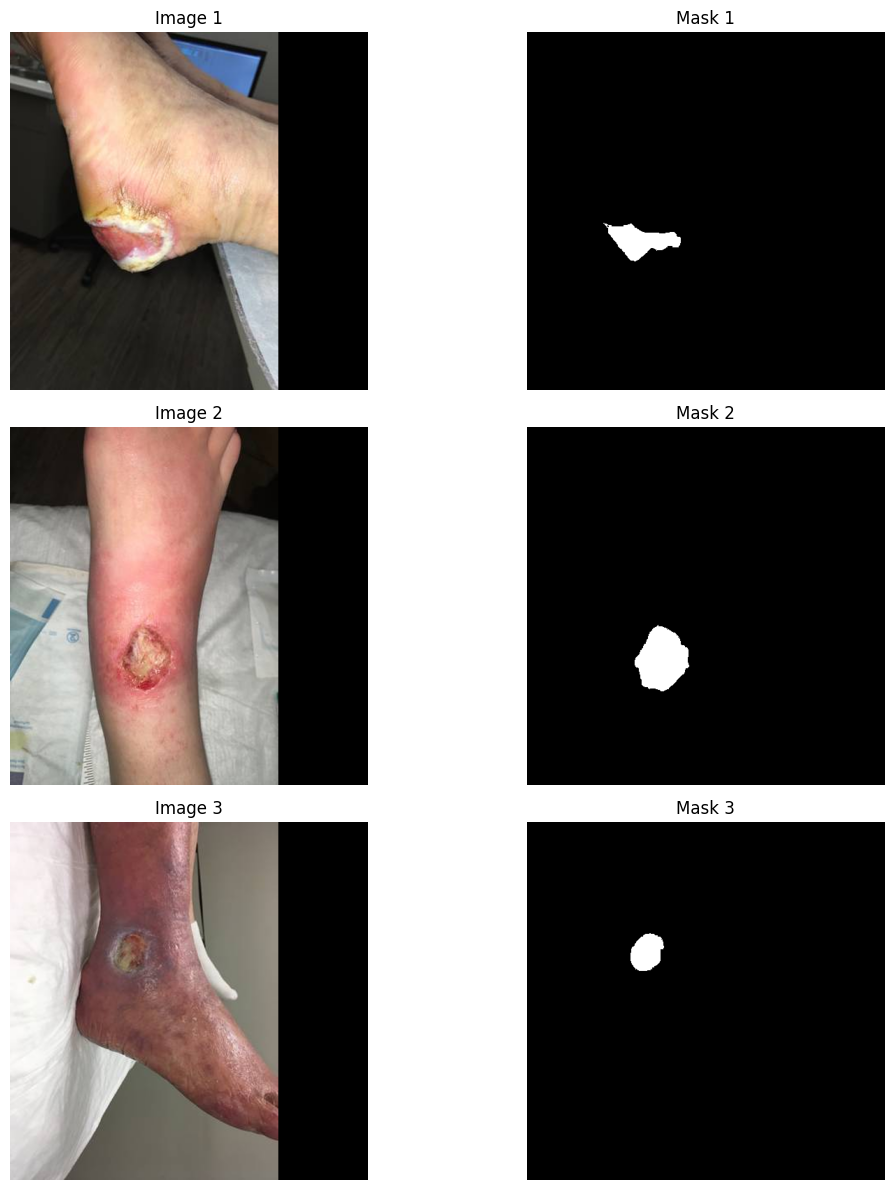

In [3]:
import matplotlib.pyplot as plt
import cv2

def display_samples(images, masks, num_samples=5):
    """
    Displays a sample of images and their corresponding masks side by side.

    Args:
        images (list): List of paths to image files.
        masks (list): List of paths to mask files.
        num_samples (int): Number of samples to display (default is 5).

    Raises:
        ValueError: If the number of images and masks do not match.
    """
    if len(images) != len(masks):
        raise ValueError("The number of images and masks must be the same.")

    # Set up the figure for visualization
    plt.figure(figsize=(12, num_samples * 4))

    for i in range(num_samples):
        # Load and preprocess the image
        img = cv2.imread(images[i])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for correct display

        # Load the mask in grayscale
        mask = cv2.imread(masks[i], cv2.IMREAD_GRAYSCALE)

        # Display the image
        plt.subplot(num_samples, 2, 2 * i + 1)
        plt.imshow(img)
        plt.title(f'Image {i + 1}')
        plt.axis('off')

        # Display the corresponding mask
        plt.subplot(num_samples, 2, 2 * i + 2)
        plt.imshow(mask, cmap='gray')
        plt.title(f'Mask {i + 1}')
        plt.axis('off')

    # Adjust layout for better visualization
    plt.tight_layout()
    plt.show()

# Example usage: Display 3 samples from the training set
display_samples(train_images, train_masks, num_samples=3)

In [4]:
import numpy as np
import cv2
from tensorflow.keras.utils import Sequence

# Constants for configuration
IMG_HEIGHT = 256  # Target image height
IMG_WIDTH = 256   # Target image width
BATCH_SIZE = 16   # Batch size for training
NORMALIZE_FACTOR = 255.0  # Normalization factor for pixel values

class DataGenerator(Sequence):
    """
    Custom data generator for loading and augmenting images and masks in batches.

    Args:
        image_filenames (list): List of paths to image files.
        mask_filenames (list): List of paths to mask files.
        batch_size (int): Number of samples per batch.
        img_height (int): Target height for resizing images and masks.
        img_width (int): Target width for resizing images and masks.
        augment (bool): Whether to apply data augmentation (default is False).
    """

    def __init__(self, image_filenames, mask_filenames, batch_size, img_height, img_width, augment=False):
        self.image_filenames = image_filenames
        self.mask_filenames = mask_filenames
        self.batch_size = batch_size
        self.img_height = img_height
        self.img_width = img_width
        self.augment = augment

    def __len__(self):
        """Returns the number of batches per epoch."""
        return int(np.ceil(len(self.image_filenames) / self.batch_size))

    def __getitem__(self, idx):
        """Generates one batch of data."""
        batch_x = self.image_filenames[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.mask_filenames[idx * self.batch_size:(idx + 1) * self.batch_size]

        images, masks = [], []
        for img_path, mask_path in zip(batch_x, batch_y):
            img = self._load_and_preprocess_image(img_path)
            mask = self._load_and_preprocess_mask(mask_path)

            if self.augment:
                img, mask = self._apply_augmentation(img, mask)

            images.append(img)
            masks.append(mask)

        return np.array(images), np.array(masks)

    def _load_and_preprocess_image(self, img_path):
        """Loads and preprocesses an image."""
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
        img = cv2.resize(img, (self.img_width, self.img_height))  # Resize
        img = img / NORMALIZE_FACTOR  # Normalize to [0, 1]
        img = img.astype(np.float32)  # Cast to float32
        return img

    def _load_and_preprocess_mask(self, mask_path):
        """Loads and preprocesses a mask."""
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)  # Read in grayscale
        mask = cv2.resize(mask, (self.img_width, self.img_height))  # Resize
        mask = np.expand_dims(mask, axis=-1)  # Add channel dimension
        mask = mask / NORMALIZE_FACTOR  # Normalize to [0, 1]
        mask = mask.astype(np.float32)  # Cast to float32
        return mask

    def _apply_augmentation(self, img, mask):
        """Applies random augmentation to an image and its mask."""
        # Random horizontal flip
        if np.random.rand() > 0.5:
            img = np.fliplr(img)
            mask = np.fliplr(mask)

        # Random vertical flip
        if np.random.rand() > 0.5:
            img = np.flipud(img)
            mask = np.flipud(mask)

        # Random rotation
        angle = np.random.randint(-15, 15)
        M = cv2.getRotationMatrix2D((self.img_width / 2, self.img_height / 2), angle, 1)
        img = cv2.warpAffine(img, M, (self.img_width, self.img_height)).astype(np.float32)
        mask = cv2.warpAffine(mask, M, (self.img_width, self.img_height)).astype(np.float32)

        return img, mask

# Create data generators
train_generator = DataGenerator(train_images, train_masks, BATCH_SIZE, IMG_HEIGHT, IMG_WIDTH, augment=True)
test_generator = DataGenerator(test_images, test_masks, BATCH_SIZE, IMG_HEIGHT, IMG_WIDTH)

In [5]:
import numpy as np
import cv2
from tensorflow.keras.utils import Sequence

class DataGenerator(Sequence):
    """
    Custom data generator for loading and augmenting images and masks in batches.

    Args:
        image_filenames (list): List of paths to image files.
        mask_filenames (list): List of paths to mask files.
        batch_size (int): Number of samples per batch.
        img_height (int): Target height for resizing images and masks.
        img_width (int): Target width for resizing images and masks.
        augment (bool): Whether to apply data augmentation (default is False).
    """

    def __init__(self, image_filenames, mask_filenames, batch_size, img_height, img_width, augment=False):
        self.image_filenames = image_filenames
        self.mask_filenames = mask_filenames
        self.batch_size = batch_size
        self.img_height = img_height
        self.img_width = img_width
        self.augment = augment

    def __len__(self):
        """Returns the number of batches per epoch."""
        return int(np.ceil(len(self.image_filenames) / self.batch_size))

    def __getitem__(self, idx):
        """Generates one batch of data."""
        batch_x = self.image_filenames[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.mask_filenames[idx * self.batch_size:(idx + 1) * self.batch_size]

        images, masks = [], []
        for img_path, mask_path in zip(batch_x, batch_y):
            img = self._load_and_preprocess_image(img_path)
            mask = self._load_and_preprocess_mask(mask_path)

            if self.augment:
                img, mask = self._apply_augmentation(img, mask)

            images.append(img)
            masks.append(mask)

        return np.array(images), np.array(masks)

    def _load_and_preprocess_image(self, img_path):
        """Loads and preprocesses an image."""
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
        img = cv2.resize(img, (self.img_width, self.img_height))  # Resize
        img = img / 255.0  # Normalize to [0, 1]
        return img

    def _load_and_preprocess_mask(self, mask_path):
        """Loads and preprocesses a mask."""
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)  # Read in grayscale
        mask = cv2.resize(mask, (self.img_width, self.img_height))  # Resize
        mask = np.expand_dims(mask, axis=-1)  # Add channel dimension
        mask = mask / 255.0  # Normalize to [0, 1]
        return mask

    def _apply_augmentation(self, img, mask):
        """Applies random augmentation to an image and its mask."""
        # Random horizontal flip
        if np.random.rand() > 0.5:
            img = np.fliplr(img)
            mask = np.fliplr(mask)

        # Random vertical flip
        if np.random.rand() > 0.5:
            img = np.flipud(img)
            mask = np.flipud(mask)

        # Random rotation
        angle = np.random.randint(-15, 15)
        M = cv2.getRotationMatrix2D((self.img_width / 2, self.img_height / 2), angle, 1)
        img = cv2.warpAffine(img, M, (self.img_width, self.img_height))
        mask = cv2.warpAffine(mask, M, (self.img_width, self.img_height))

        return img, mask

In [6]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Dropout, MaxPooling2D, Conv2DTranspose, concatenate
from tensorflow.keras.models import Model

def unet_model(input_size=(256, 256, 3)):
    """
    Defines a U-Net model for image segmentation.

    Args:
        input_size (tuple): Input image dimensions (height, width, channels). Default is (256, 256, 3).

    Returns:
        model (tf.keras.Model): A U-Net model.
    """
    inputs = Input(input_size)

    # Encoder (Downsampling Path)
    def encoder_block(input_tensor, filters, dropout_rate):
        """Creates an encoder block with two convolutional layers, batch normalization, and dropout."""
        x = Conv2D(filters, (3, 3), activation='relu', padding='same')(input_tensor)
        x = BatchNormalization()(x)
        x = Dropout(dropout_rate)(x)
        x = Conv2D(filters, (3, 3), activation='relu', padding='same')(x)
        p = MaxPooling2D((2, 2))(x)
        return x, p

    c1, p1 = encoder_block(inputs, 64, 0.1)
    c2, p2 = encoder_block(p1, 128, 0.1)
    c3, p3 = encoder_block(p2, 256, 0.2)
    c4, p4 = encoder_block(p3, 512, 0.2)

    # Bridge
    bridge = Conv2D(1024, (3, 3), activation='relu', padding='same')(p4)
    bridge = BatchNormalization()(bridge)
    bridge = Dropout(0.3)(bridge)
    bridge = Conv2D(1024, (3, 3), activation='relu', padding='same')(bridge)

    # Decoder (Upsampling Path)
    def decoder_block(input_tensor, skip_tensor, filters, dropout_rate):
        """Creates a decoder block with upsampling, concatenation, and two convolutional layers."""
        x = Conv2DTranspose(filters, (2, 2), strides=(2, 2), padding='same')(input_tensor)
        x = concatenate([x, skip_tensor])
        x = Conv2D(filters, (3, 3), activation='relu', padding='same')(x)
        x = BatchNormalization()(x)
        x = Dropout(dropout_rate)(x)
        x = Conv2D(filters, (3, 3), activation='relu', padding='same')(x)
        return x

    d1 = decoder_block(bridge, c4, 512, 0.2)
    d2 = decoder_block(d1, c3, 256, 0.2)
    d3 = decoder_block(d2, c2, 128, 0.1)
    d4 = decoder_block(d3, c1, 64, 0.1)

    # Output Layer
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(d4)

    # Create the model
    model = Model(inputs=[inputs], outputs=[outputs])
    return model

# Instantiate the model
model = unet_model()

# Print the model summary
model.summary()


I0000 00:00:1750654643.835809      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1750654643.836448      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 256, 256, 64)   │          1,792 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 256, 256, 64)   │            256 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 256, 256, 64)   │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 256, 256, 64)   │         36,928 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 128, 128, 64)   │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 128, 128, 128)  │         73,856 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 128, 128, 128)  │            512 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 128, 128, 128)  │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 128, 128, 128)  │        147,584 │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 64, 64, 128)    │              0 │ conv2d_3[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 64, 64, 256)    │        295,168 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 64, 64, 256)    │          1,024 │ conv2d_4[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 64, 64, 256)    │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 64, 64, 256)    │        590,080 │ dropout_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 32, 32, 256)    │              0 │ conv2d_5[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)    

 Total params: 31,043,521 (118.42 MB)

 Trainable params: 31,037,633 (118.40 MB)

 Non-trainable params: 5,888 (23.00 KB)

In [7]:
import tensorflow.keras.backend as K

def dice_coefficient(y_true, y_pred, smooth=1):
    """
    Computes the Dice Coefficient, a metric for evaluating segmentation performance.

    Args:
        y_true (tensor): Ground truth labels.
        y_pred (tensor): Predicted labels.
        smooth (float): Smoothing factor to avoid division by zero. Default is 1.

    Returns:
        dice (tensor): Dice Coefficient score.
    """
    # Flatten and cast tensors to float32
    y_true_f = K.flatten(K.cast(y_true, 'float32'))
    y_pred_f = K.flatten(K.cast(y_pred, 'float32'))

    # Compute intersection and Dice Coefficient
    intersection = K.sum(y_true_f * y_pred_f)
    dice = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return dice

def iou_metric(y_true, y_pred, smooth=1):
    """
    Computes the Intersection over Union (IoU), a metric for evaluating segmentation performance.

    Args:
        y_true (tensor): Ground truth labels.
        y_pred (tensor): Predicted labels.
        smooth (float): Smoothing factor to avoid division by zero. Default is 1.

    Returns:
        iou (tensor): IoU score.
    """
    # Flatten and cast tensors to float32
    y_true_f = K.flatten(K.cast(y_true, 'float32'))
    y_pred_f = K.flatten(K.cast(y_pred, 'float32'))

    # Compute intersection and union
    intersection = K.sum(y_true_f * y_pred_f)
    union = K.sum(y_true_f) + K.sum(y_pred_f) - intersection

    # Compute IoU
    iou = (intersection + smooth) / (union + smooth)
    return iou

In [8]:
from tensorflow.keras.optimizers import Adam

model.compile(
    optimizer=Adam(learning_rate=1e-4),  
    loss='binary_crossentropy',          
    metrics=[
        'accuracy',                     
        dice_coefficient,                
        iou_metric     
    ] 
)

In [9]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

# Define custom metrics
def dice_coefficient(y_true, y_pred, smooth=1):
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + smooth)

def iou_metric(y_true, y_pred, smooth=1):
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    union = tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) - intersection
    return (intersection + smooth) / (union + smooth)

# Callbacks for training
def get_callbacks(): 
    """
    Creates and returns a list of callbacks for model training.

    Returns:
        list: A list of callbacks including ModelCheckpoint, EarlyStopping, and ReduceLROnPlateau.
    """
    checkpoint = ModelCheckpoint(
        'unet_wound_segmentation_best.keras',
        monitor='val_loss',
        save_best_only=True,
        verbose=1,
        mode='min'
    )

    earlystop = EarlyStopping(
        monitor='val_loss',
        patience=15,
        verbose=1,
        restore_best_weights=True
    )

    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=7,
        verbose=1,
        mode='min',
        min_lr=1e-6
    )

    return [checkpoint, earlystop, reduce_lr]

# Compile the model
def compile_model(model):
    """
    Compiles the model with Adam optimizer, binary cross-entropy loss, and custom metrics.

    Args:
        model (tf.keras.Model): The model to compile.
    """
    model.compile(
        optimizer=Adam(learning_rate=1e-4),
        loss='binary_crossentropy',
        metrics=['accuracy', dice_coefficient, iou_metric]
    )

# Train the model
def train_model(model, train_generator, test_generator, epochs=50):
    """
    Trains the model using the provided data generators and callbacks.

    Args:
        model (tf.keras.Model): The model to train.
        train_generator (DataGenerator): Training data generator.
        test_generator (DataGenerator): Validation data generator.
        epochs (int): Number of training epochs. Default is 100.

    Returns:
        history: Training history object.
    """
    callbacks_list = get_callbacks()

    history = model.fit(
        train_generator,
        validation_data=test_generator,
        epochs=epochs,
        callbacks=callbacks_list,
        verbose=1
    )
    return history

# === Example Usage ===
# Assuming you have `model`, `train_generator`, and `test_generator` already defined

compile_model(model)
history = train_model(model, train_generator, test_generator, epochs=100)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 256, 256, 3))
  warnings.warn(msg)
I0000 00:00:1750654661.077087      68 service.cc:148] XLA service 0x7f20500080b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1750654661.077584      68 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1750654661.077606      68 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1750654662.570562      68 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-06-23 04:57:48.856536: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng12{k11=0} for conv (f32[16,128,128,128]{3,2,1,0}, u8[0]{0}) custom-call(f32[16,128,128,128]{3,2,1,0}, f32[128,128,3,3]{3,2,1,0}, f32[128]{0}), window={size=

138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 913ms/step - accuracy: 0.8961 - dice_coefficient: 0.1426 - iou_metric: 0.0797 - loss: 0.2626
Epoch 1: val_loss improved from inf to 0.08015, saving model to unet_wound_segmentation_best.keras
138/138 ━━━━━━━━━━━━━━━━━━━━ 267s 1s/step - accuracy: 0.8964 - dice_coefficient: 0.1430 - iou_metric: 0.0799 - loss: 0.2620 - val_accuracy: 0.9860 - val_dice_coefficient: 0.0187 - val_iou_metric: 0.0094 - val_loss: 0.0801 - learning_rate: 1.0000e-04
Epoch 2/100
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 910ms/step - accuracy: 0.9598 - dice_coefficient: 0.2796 - iou_metric: 0.1675 - loss: 0.1055
Epoch 2: val_loss improved from 0.08015 to 0.07531, saving model to unet_wound_segmentation_best.keras
138/138 ━━━━━━━━━━━━━━━━━━━━ 139s 1s/step - accuracy: 0.9598 - dice_coefficient: 0.2797 - iou_metric: 0.1675 - loss: 0.1056 - val_accuracy: 0.9860 - val_dice_coefficient: 0.0080 - val_iou_metric: 0.0041 - val_loss: 0.0753 - learning_rate: 1.0000e-04
Epoch 3/100
138/138 ━━━━━━━━━━━━━━━━

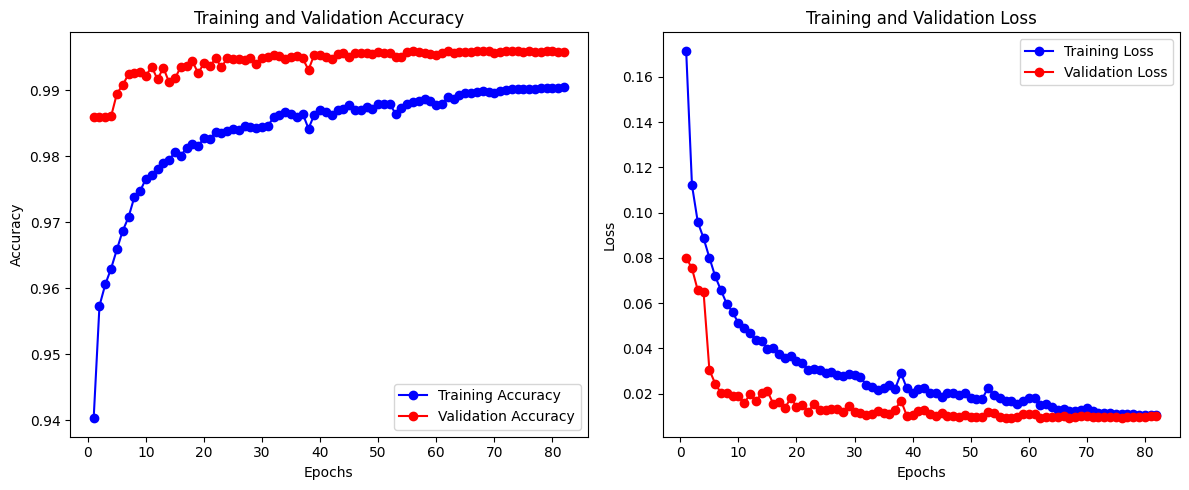

In [10]:
import matplotlib.pyplot as plt  

def plot_training_history(history):
    """
    Plots the training and validation accuracy and loss over epochs

    Args: 
        history (tf.keras.callbacks.History): The history object returned by model. fit.

    Returns:
        None
    """
    # Extract metrics from the history object
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)
     
    # Plot training and validation accuracy
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'bo-', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'ro-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot training and validation loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'bo-', label='Training Loss')
    plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Example usage
plot_training_history(history)


In [11]:
# Predict on the test dataset
test_predictions = model.predict(test_generator)

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(16, 256, 256, 3))
  warnings.warn(msg)


35/35 ━━━━━━━━━━━━━━━━━━━━ 14s 351ms/step


In [12]:
# Evaluate the model on the test data
test_loss, test_accuracy, test_dice, test_iou = model.evaluate(test_generator, verbose=1)

# Print the test accuracy
print(f"Test Accuracy: {test_accuracy:.4f}")

35/35 ━━━━━━━━━━━━━━━━━━━━ 11s 316ms/step - accuracy: 0.9961 - dice_coefficient: 0.8149 - iou_metric: 0.6890 - loss: 0.0088
Test Accuracy: 0.9960


35/35 ━━━━━━━━━━━━━━━━━━━━ 11s 318ms/step - accuracy: 0.9961 - dice_coefficient: 0.8149 - iou_metric: 0.6890 - loss: 0.0088
Test Accuracy: 0.9960
Test Dice Coefficient: 0.8243
Test IoU: 0.7032


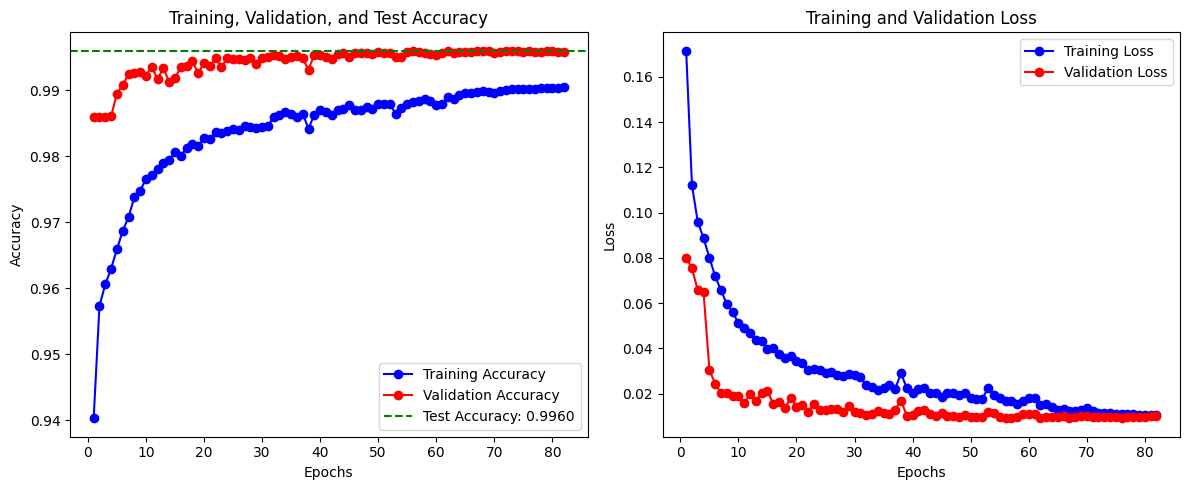

In [13]:
import matplotlib.pyplot as plt

def plot_training_history(history, test_accuracy=None):
    """
    Plots the training and validation accuracy and loss over epochs.
    Optionally, adds a horizontal line for Test Accuracy.

    Args:
        history (tf.keras.callbacks.History): The history object returned by model.fit.
        test_accuracy (float): Test accuracy to display on the plot (optional).

    Returns:
        None
    """
    # Extract metrics from the history object
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)  # Epochs for the x-axis

    # Plot training and validation accuracy
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'bo-', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'ro-', label='Validation Accuracy')
    
    # Add Test Accuracy as a horizontal line
    if test_accuracy is not None:
        plt.axhline(y=test_accuracy, color='g', linestyle='--', label=f'Test Accuracy: {test_accuracy:.4f}')
    
    plt.title('Training, Validation, and Test Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot training and validation loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'bo-', label='Training Loss')
    plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

#Evaluate the model on the test data
test_loss, test_accuracy, test_dice, test_iou = model.evaluate(test_generator, verbose=1)

# Print the test accuracy
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Dice Coefficient: {test_dice:.4f}")
print(f"Test IoU: {test_iou:.4f}")

# Plot training history with Test Accuracy
plot_training_history(history, test_accuracy) 

In [14]:
# Save the model in .h5 format
model.save('unet_wound_segmentation_model.h5')

In [15]:
from sklearn.metrics import precision_score, recall_score, f1_score

# 1. Get true masks and predictions (same as before)
def get_true_and_predicted_masks(generator, model):
    true_masks = []
    predicted_masks = []
    
    for i in tqdm(range(len(generator))):
        batch_images, batch_masks = generator[i]
        batch_preds = model.predict(batch_images, verbose=0)
        true_masks.append(batch_masks)
        predicted_masks.append(batch_preds)
    
    return np.concatenate(true_masks), np.concatenate(predicted_masks)

true_masks, pred_masks = get_true_and_predicted_masks(test_generator, model)

# 2. Threshold and convert to integers
threshold = 0.5
binary_preds = (pred_masks > threshold).astype(np.int8)  # Convert to integers
binary_true = (true_masks > threshold).astype(np.int8)   # Ensure ground truth is also binary

# 3. Flatten arrays
y_true = binary_true.flatten()
y_pred = binary_preds.flatten()

# 4. Calculate metrics
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

# 5. Get other metrics from model evaluation
test_loss, test_acc, test_dice, test_iou = model.evaluate(test_generator, verbose=0)

# 6. Create report
report = {
    "Test Accuracy": f"{test_acc:.4f}",
    "Test Dice Coefficient": f"{test_dice:.4f}",
    "Test IoU": f"{test_iou:.4f}",
    "Precision": f"{precision:.4f}",
    "Recall": f"{recall:.4f}",
    "F1 Score": f"{f1:.4f}"
}

# 7. Print formatted report
print("Model Performance Report:")
print("="*40)
for metric, value in report.items():
    print(f"{metric:20}: {value}")
print("="*40)

100%|██████████| 35/35 [00:22<00:00,  1.57it/s]


Model Performance Report:
Test Accuracy       : 0.9960
Test Dice Coefficient: 0.8243
Test IoU            : 0.7032
Precision           : 0.8716
Recall              : 0.8839
F1 Score            : 0.8777


1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


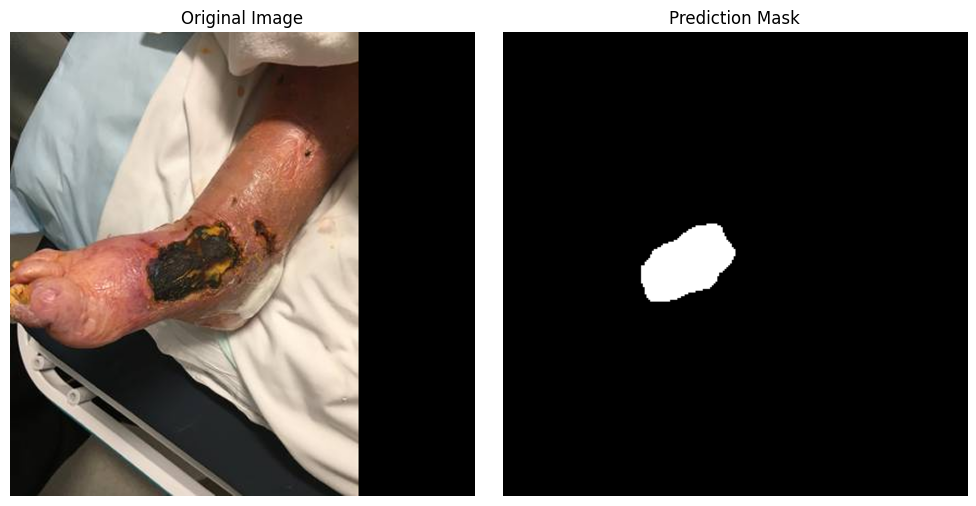

In [16]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# Load the trained model
model = load_model('unet_wound_segmentation_model.h5', custom_objects={'dice_coefficient': dice_coefficient, 'iou_metric': iou_metric})

def preprocess_image(image_path, target_size=(256, 256)):
    """
    Load and preprocess an image for prediction.

    Args:
        image_path (str): Path to the image file.
        target_size (tuple): Target size for resizing the image. Default is (256, 256).

    Returns:
        np.array: Preprocessed image.
    """
    # Load the image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
    image = cv2.resize(image, target_size)  # Resize to target size
    image = image / 255.0  # Normalize to [0, 1]
    image = np.expand_dims(image, axis=0)  # Add batch dimension
    return image

def display_prediction(image_path, model):
    """
    Display the original image and its prediction (segmentation mask).

    Args:
        image_path (str): Path to the image file.
        model (tf.keras.Model): Trained model for prediction.

    Returns:
        None
    """
    # Preprocess the image
    image = preprocess_image(image_path)

    # Generate prediction
    prediction = model.predict(image)
    prediction_mask = (prediction.squeeze() > 0.5).astype(np.uint8)  # Apply threshold (0.5)

    # Load the original image for display
    original_image = cv2.imread(image_path)
    original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)

    # Display the original image and the prediction
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(original_image)
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(prediction_mask, cmap='gray')
    plt.title('Prediction Mask')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

# Test the model on a new image
test_image_path = '/kaggle/input/wound-segmentation-images/data_wound_seg/test_images/fusc_0021.png'  
display_prediction(test_image_path, model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


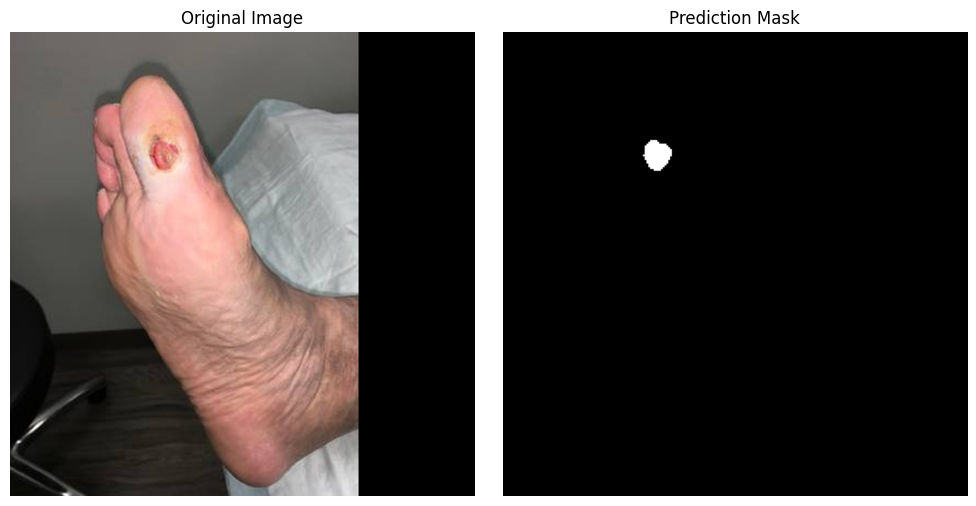

In [17]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# Load the trained model
model = load_model('unet_wound_segmentation_model.h5', custom_objects={'dice_coefficient': dice_coefficient, 'iou_metric': iou_metric})

def preprocess_image(image_path, target_size=(256, 256)):
    """
    Load and preprocess an image for prediction.

    Args:
        image_path (str): Path to the image file.
        target_size (tuple): Target size for resizing the image. Default is (256, 256).

    Returns:
        np.array: Preprocessed image.
    """
    # Load the image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
    image = cv2.resize(image, target_size)  # Resize to target size
    image = image / 255.0  # Normalize to [0, 1]
    image = np.expand_dims(image, axis=0)  # Add batch dimension
    return image

def display_prediction(image_path, model):
    """
    Display the original image and its prediction (segmentation mask).

    Args:
        image_path (str): Path to the image file.
        model (tf.keras.Model): Trained model for prediction.

    Returns:
        None
    """
    # Preprocess the image
    image = preprocess_image(image_path)

    # Generate prediction
    prediction = model.predict(image)
    prediction_mask = (prediction.squeeze() > 0.5).astype(np.uint8)  # Apply threshold (0.5)

    # Load the original image for display
    original_image = cv2.imread(image_path)
    original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)

    # Display the original image and the prediction
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(original_image)
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(prediction_mask, cmap='gray')
    plt.title('Prediction Mask')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

# Test the model on a new image
test_image_path = '/kaggle/input/wound-segmentation-images/data_wound_seg/test_images/fusc_0024.png'  
display_prediction(test_image_path, model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


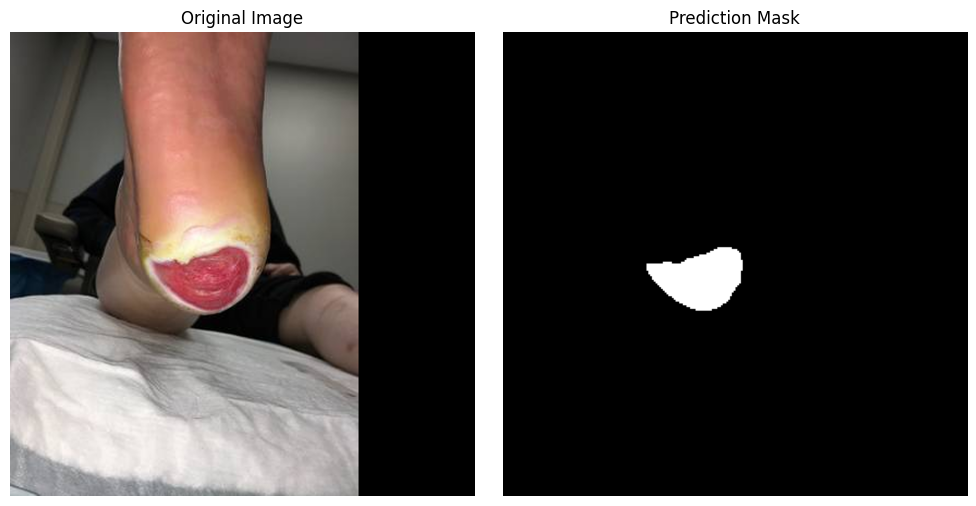

In [18]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# Load the trained model
model = load_model('unet_wound_segmentation_model.h5', custom_objects={'dice_coefficient': dice_coefficient, 'iou_metric': iou_metric})

def preprocess_image(image_path, target_size=(256, 256)):
    """
    Load and preprocess an image for prediction.

    Args:
        image_path (str): Path to the image file.
        target_size (tuple): Target size for resizing the image. Default is (256, 256).

    Returns:
        np.array: Preprocessed image.
    """
    # Load the image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
    image = cv2.resize(image, target_size)  # Resize to target size
    image = image / 255.0  # Normalize to [0, 1]
    image = np.expand_dims(image, axis=0)  # Add batch dimension
    return image

def display_prediction(image_path, model):
    """
    Display the original image and its prediction (segmentation mask).

    Args:
        image_path (str): Path to the image file.
        model (tf.keras.Model): Trained model for prediction.

    Returns:
        None
    """
    # Preprocess the image
    image = preprocess_image(image_path)

    # Generate prediction
    prediction = model.predict(image)
    prediction_mask = (prediction.squeeze() > 0.5).astype(np.uint8)  # Apply threshold (0.5)

    # Load the original image for display
    original_image = cv2.imread(image_path)
    original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)

    # Display the original image and the prediction
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(original_image)
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(prediction_mask, cmap='gray')
    plt.title('Prediction Mask')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

# Test the model on a new image
test_image_path = '/kaggle/input/wound-segmentation-images/data_wound_seg/test_images/fusc_0030.png'  
display_prediction(test_image_path, model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


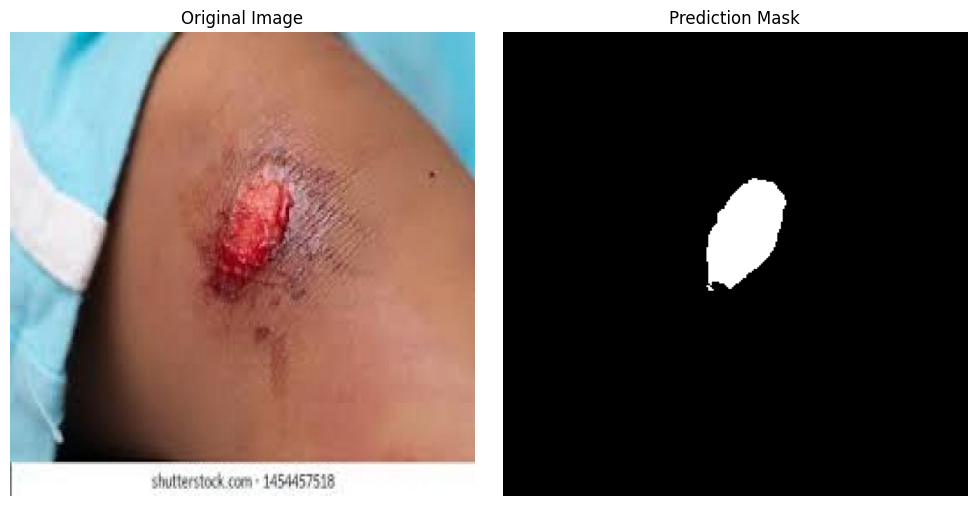

In [19]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# Load the trained model
model = load_model('unet_wound_segmentation_model.h5', custom_objects={'dice_coefficient': dice_coefficient, 'iou_metric': iou_metric})

def preprocess_image(image_path, target_size=(256, 256)):
    """
    Load and preprocess an image for prediction.

    Args:
        image_path (str): Path to the image file.
        target_size (tuple): Target size for resizing the image. Default is (256, 256).

    Returns:
        np.array: Preprocessed image.
    """
    # Load the image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
    image = cv2.resize(image, target_size)  # Resize to target size
    image = image / 255.0  # Normalize to [0, 1]
    image = np.expand_dims(image, axis=0)  # Add batch dimension
    return image

def display_prediction(image_path, model):
    """
    Display the original image and its prediction (segmentation mask).

    Args:
        image_path (str): Path to the image file.
        model (tf.keras.Model): Trained model for prediction.

    Returns:
        None
    """
    # Preprocess the image
    image = preprocess_image(image_path)

    # Generate prediction
    prediction = model.predict(image)
    prediction_mask = (prediction.squeeze() > 0.5).astype(np.uint8)  # Apply threshold (0.5)

    # Load the original image for display
    original_image = cv2.imread(image_path)
    original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)

    # Display the original image and the prediction
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(original_image)
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(prediction_mask, cmap='gray')
    plt.title('Prediction Mask')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

# Test the model on a new image
test_image_path = '/kaggle/input/wound-classification/Wound_dataset copy/Abrasions/abrasions (10).jpg'  
display_prediction(test_image_path, model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


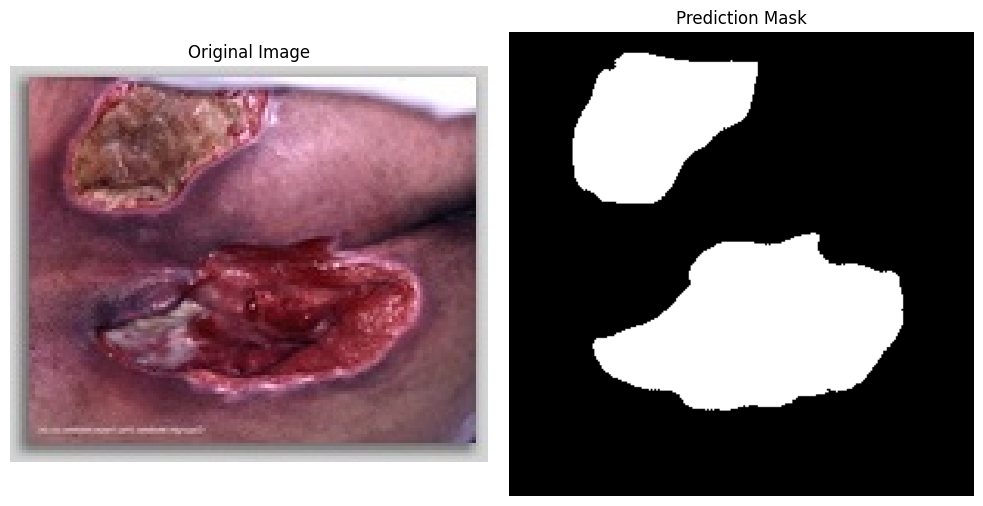

In [20]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# Load the trained model
model = load_model('unet_wound_segmentation_model.h5', custom_objects={'dice_coefficient': dice_coefficient, 'iou_metric': iou_metric})

def preprocess_image(image_path, target_size=(256, 256)):
    """
    Load and preprocess an image for prediction.

    Args:
        image_path (str): Path to the image file.
        target_size (tuple): Target size for resizing the image. Default is (256, 256).

    Returns:
        np.array: Preprocessed image.
    """
    # Load the image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
    image = cv2.resize(image, target_size)  # Resize to target size
    image = image / 255.0  # Normalize to [0, 1]
    image = np.expand_dims(image, axis=0)  # Add batch dimension
    return image

def display_prediction(image_path, model):
    """
    Display the original image and its prediction (segmentation mask).

    Args:
        image_path (str): Path to the image file.
        model (tf.keras.Model): Trained model for prediction.

    Returns:
        None
    """
    # Preprocess the image
    image = preprocess_image(image_path)

    # Generate prediction
    prediction = model.predict(image)
    prediction_mask = (prediction.squeeze() > 0.5).astype(np.uint8)  # Apply threshold (0.5)

    # Load the original image for display
    original_image = cv2.imread(image_path)
    original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)

    # Display the original image and the prediction
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(original_image)
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(prediction_mask, cmap='gray')
    plt.title('Prediction Mask')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

# Test the model on a new image
test_image_path = '/kaggle/input/wound-classification/Wound_dataset copy/Pressure Wounds/mirrored_sloughy-pressure-ulcer-0038.jpg'  
display_prediction(test_image_path, model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


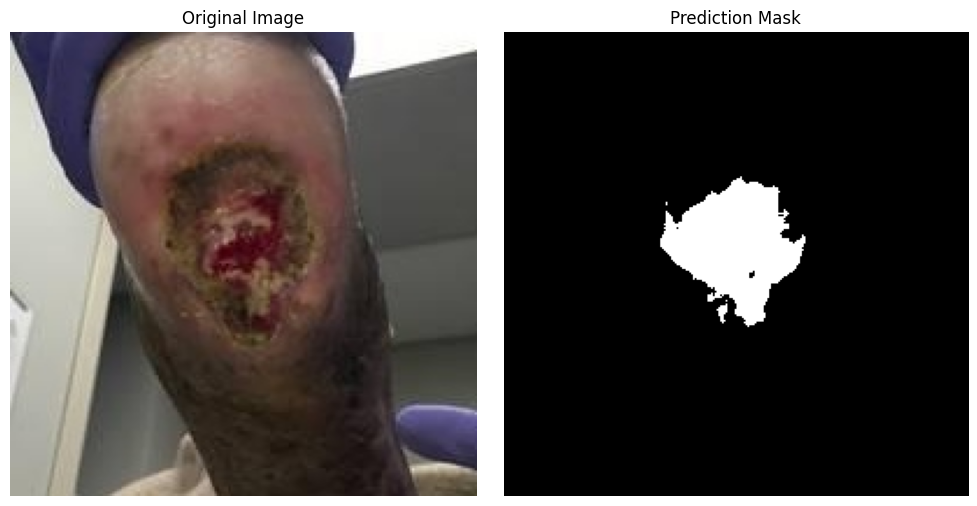

In [21]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# Load the trained model
model = load_model('unet_wound_segmentation_model.h5', custom_objects={'dice_coefficient': dice_coefficient, 'iou_metric': iou_metric})

def preprocess_image(image_path, target_size=(256, 256)):
    """
    Load and preprocess an image for prediction.

    Args:
        image_path (str): Path to the image file.
        target_size (tuple): Target size for resizing the image. Default is (256, 256).

    Returns:
        np.array: Preprocessed image.
    """
    # Load the image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
    image = cv2.resize(image, target_size)  # Resize to target size
    image = image / 255.0  # Normalize to [0, 1]
    image = np.expand_dims(image, axis=0)  # Add batch dimension
    return image

def display_prediction(image_path, model):
    """
    Display the original image and its prediction (segmentation mask).

    Args:
        image_path (str): Path to the image file.
        model (tf.keras.Model): Trained model for prediction.

    Returns:
        None
    """
    # Preprocess the image
    image = preprocess_image(image_path)

    # Generate prediction
    prediction = model.predict(image)
    prediction_mask = (prediction.squeeze() > 0.5).astype(np.uint8)  # Apply threshold (0.5)

    # Load the original image for display
    original_image = cv2.imread(image_path)
    original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)

    # Display the original image and the prediction
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(original_image)
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(prediction_mask, cmap='gray')
    plt.title('Prediction Mask')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

# Test the model on a new image
test_image_path = '/kaggle/input/wound-classification/Wound_dataset copy/Diabetic Wounds/103_0.jpg'  
display_prediction(test_image_path, model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


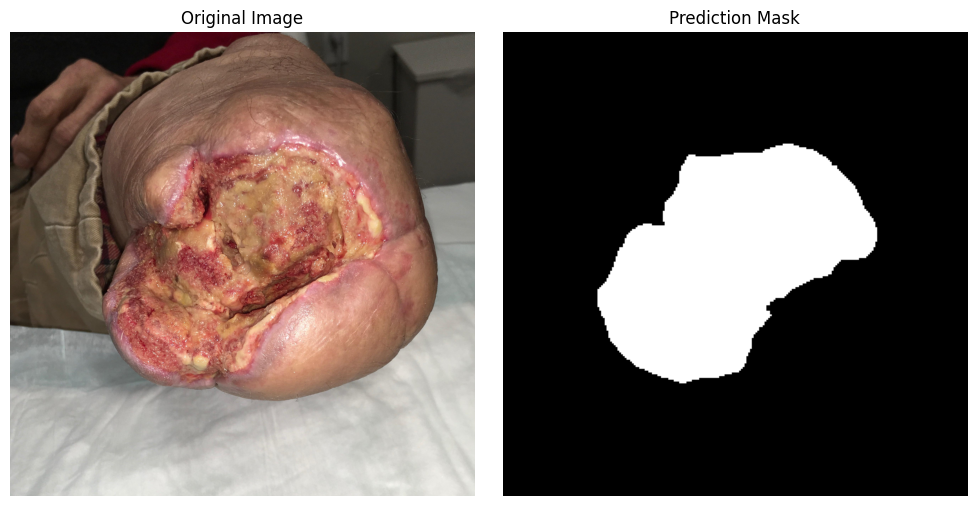

In [22]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# Load the trained model
model = load_model('unet_wound_segmentation_model.h5', custom_objects={'dice_coefficient': dice_coefficient, 'iou_metric': iou_metric})

def preprocess_image(image_path, target_size=(256, 256)):
    """
    Load and preprocess an image for prediction.

    Args:
        image_path (str): Path to the image file.
        target_size (tuple): Target size for resizing the image. Default is (256, 256).

    Returns:
        np.array: Preprocessed image.
    """
    # Load the image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
    image = cv2.resize(image, target_size)  # Resize to target size
    image = image / 255.0  # Normalize to [0, 1]
    image = np.expand_dims(image, axis=0)  # Add batch dimension
    return image

def display_prediction(image_path, model):
    """
    Display the original image and its prediction (segmentation mask).

    Args:
        image_path (str): Path to the image file.
        model (tf.keras.Model): Trained model for prediction.

    Returns:
        None
    """
    # Preprocess the image
    image = preprocess_image(image_path)

    # Generate prediction
    prediction = model.predict(image)
    prediction_mask = (prediction.squeeze() > 0.5).astype(np.uint8)  # Apply threshold (0.5)

    # Load the original image for display
    original_image = cv2.imread(image_path)
    original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)

    # Display the original image and the prediction
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(original_image)
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(prediction_mask, cmap='gray')
    plt.title('Prediction Mask')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

# Test the model on a new image
test_image_path = '/kaggle/input/wound-classification/Wound_dataset copy/Surgical Wounds/109_0.jpg'  
display_prediction(test_image_path, model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


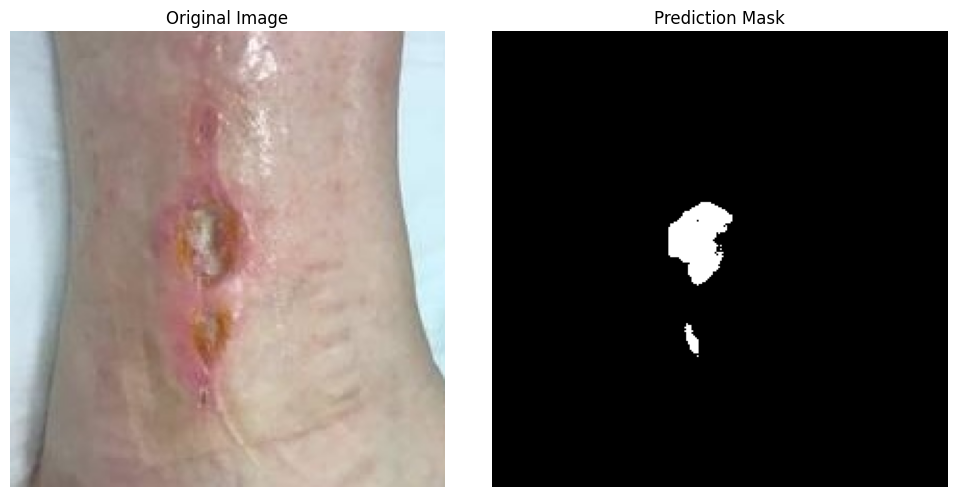

In [23]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# Load the trained model
model = load_model('unet_wound_segmentation_model.h5', custom_objects={'dice_coefficient': dice_coefficient, 'iou_metric': iou_metric})

def preprocess_image(image_path, target_size=(256, 256)):
    """
    Load and preprocess an image for prediction.

    Args:
        image_path (str): Path to the image file.
        target_size (tuple): Target size for resizing the image. Default is (256, 256).

    Returns:
        np.array: Preprocessed image.
    """
    # Load the image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
    image = cv2.resize(image, target_size)  # Resize to target size
    image = image / 255.0  # Normalize to [0, 1]
    image = np.expand_dims(image, axis=0)  # Add batch dimension
    return image

def display_prediction(image_path, model):
    """
    Display the original image and its prediction (segmentation mask).

    Args:
        image_path (str): Path to the image file.
        model (tf.keras.Model): Trained model for prediction.

    Returns:
        None
    """
    # Preprocess the image
    image = preprocess_image(image_path)

    # Generate prediction
    prediction = model.predict(image)
    prediction_mask = (prediction.squeeze() > 0.5).astype(np.uint8)  # Apply threshold (0.5)

    # Load the original image for display
    original_image = cv2.imread(image_path)
    original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)

    # Display the original image and the prediction
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(original_image)
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(prediction_mask, cmap='gray')
    plt.title('Prediction Mask')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

# Test the model on a new image
test_image_path = '/kaggle/input/wound-classification/Wound_dataset copy/Surgical Wounds/100_0.jpg'  
display_prediction(test_image_path, model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


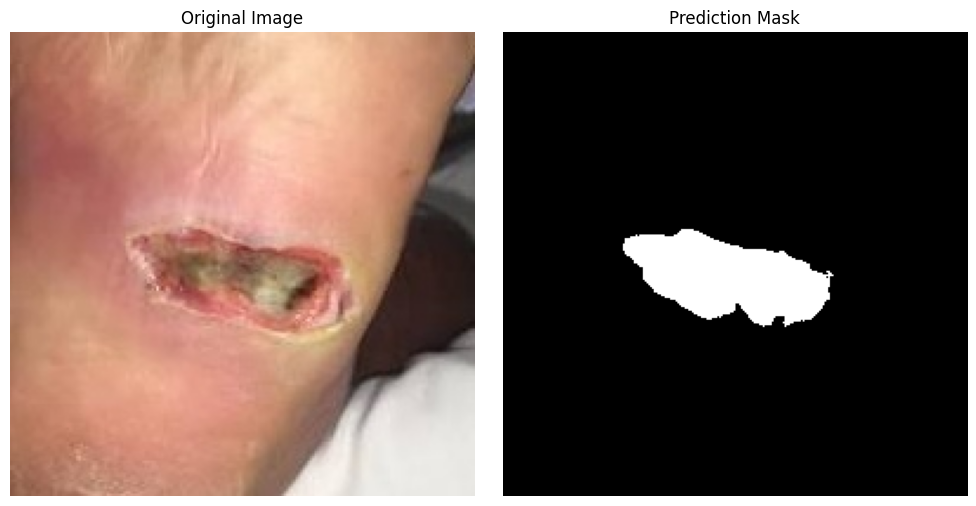

In [24]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# Load the trained model
model = load_model('unet_wound_segmentation_model.h5', custom_objects={'dice_coefficient': dice_coefficient, 'iou_metric': iou_metric})

def preprocess_image(image_path, target_size=(256, 256)):
    """
    Load and preprocess an image for prediction.

    Args:
        image_path (str): Path to the image file.
        target_size (tuple): Target size for resizing the image. Default is (256, 256).

    Returns:
        np.array: Preprocessed image.
    """
    # Load the image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
    image = cv2.resize(image, target_size)  # Resize to target size
    image = image / 255.0  # Normalize to [0, 1]
    image = np.expand_dims(image, axis=0)  # Add batch dimension
    return image

def display_prediction(image_path, model):
    """
    Display the original image and its prediction (segmentation mask).

    Args:
        image_path (str): Path to the image file.
        model (tf.keras.Model): Trained model for prediction.

    Returns:
        None
    """
    # Preprocess the image
    image = preprocess_image(image_path)

    # Generate prediction
    prediction = model.predict(image)
    prediction_mask = (prediction.squeeze() > 0.5).astype(np.uint8)  # Apply threshold (0.5)

    # Load the original image for display
    original_image = cv2.imread(image_path)
    original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)

    # Display the original image and the prediction
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(original_image)
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(prediction_mask, cmap='gray')
    plt.title('Prediction Mask')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

# Test the model on a new image
test_image_path = '/kaggle/input/wound-classification/Wound_dataset copy/Diabetic Wounds/110_0.jpg'  
display_prediction(test_image_path, model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


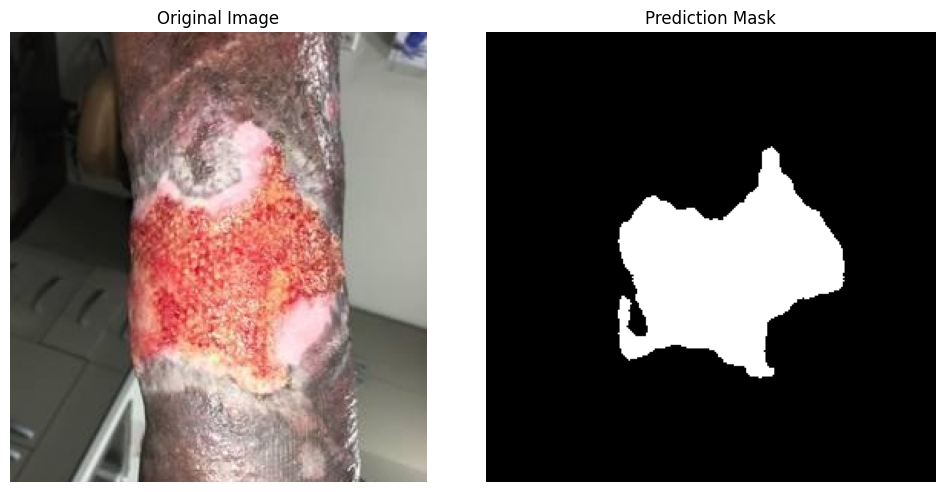

In [25]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# Load the trained model
model = load_model('unet_wound_segmentation_model.h5', custom_objects={'dice_coefficient': dice_coefficient, 'iou_metric': iou_metric})

def preprocess_image(image_path, target_size=(256, 256)):
    """
    Load and preprocess an image for prediction.

    Args:
        image_path (str): Path to the image file.
        target_size (tuple): Target size for resizing the image. Default is (256, 256).

    Returns:
        np.array: Preprocessed image.
    """
    # Load the image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
    image = cv2.resize(image, target_size)  # Resize to target size
    image = image / 255.0  # Normalize to [0, 1]
    image = np.expand_dims(image, axis=0)  # Add batch dimension
    return image

def display_prediction(image_path, model):
    """
    Display the original image and its prediction (segmentation mask).

    Args:
        image_path (str): Path to the image file.
        model (tf.keras.Model): Trained model for prediction.

    Returns:
        None
    """
    # Preprocess the image
    image = preprocess_image(image_path)

    # Generate prediction
    prediction = model.predict(image)
    prediction_mask = (prediction.squeeze() > 0.5).astype(np.uint8)  # Apply threshold (0.5)

    # Load the original image for display
    original_image = cv2.imread(image_path)
    original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)

    # Display the original image and the prediction
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(original_image)
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(prediction_mask, cmap='gray')
    plt.title('Prediction Mask')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

# Test the model on a new image
test_image_path = '/kaggle/input/wound-classification/Wound_dataset copy/Venous Wounds/110_0.jpg'  
display_prediction(test_image_path, model)

100%|██████████| 35/35 [00:21<00:00,  1.60it/s]


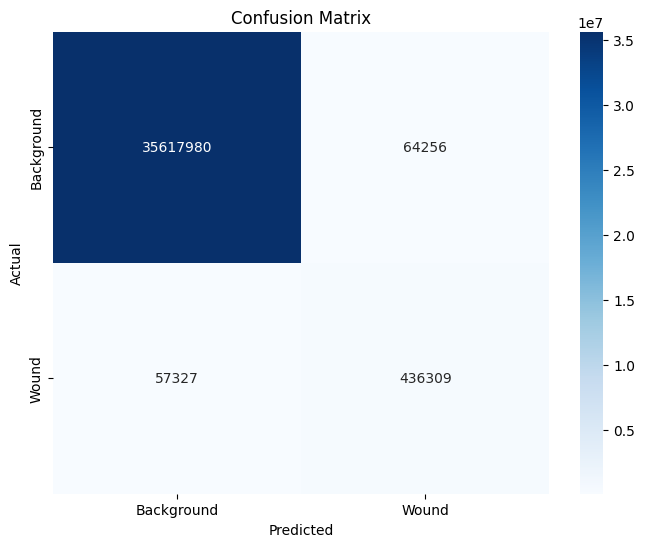

Accuracy: 0.9966
Precision: 0.8716
Recall/Sensitivity: 0.8839
Dice Coefficient: 0.8777


In [26]:
def generate_confusion_matrix(model, test_generator, threshold=0.5):
    """
    Generates a confusion matrix for segmentation results.
    
    Args:
        model: Trained model
        test_generator: Test data generator
        threshold: Threshold for binary classification of pixels
    
    Returns:
        cm: Confusion matrix as [[TN, FP], [FN, TP]]
    """
    # Initialize counters
    TN, FP, FN, TP = 0, 0, 0, 0

    # Process all test data
    for i in tqdm(range(len(test_generator))):
        batch_images, batch_masks = test_generator[i]
        pred_masks = model.predict(batch_images, verbose=0)
        
        # Threshold predictions and flatten
        y_true = batch_masks.flatten() > 0.5
        y_pred = pred_masks.flatten() > threshold

        # Update confusion matrix counts
        TN += np.sum((y_pred == False) & (y_true == False))
        FP += np.sum((y_pred == True) & (y_true == False))
        FN += np.sum((y_pred == False) & (y_true == True))
        TP += np.sum((y_pred == True) & (y_true == True))

    return np.array([[TN, FP], [FN, TP]])

def plot_confusion_matrix(cm, class_names=['Background', 'Wound']):
    """
    Plots a confusion matrix using seaborn heatmap.
    
    Args:
        cm: Confusion matrix array
        class_names: List of class names
    """
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    # Calculate metrics
    accuracy = (cm[0,0] + cm[1,1]) / cm.sum()
    precision = cm[1,1] / (cm[1,1] + cm[0,1])
    recall = cm[1,1] / (cm[1,1] + cm[1,0])
    dice = (2 * cm[1,1]) / (2 * cm[1,1] + cm[0,1] + cm[1,0])

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall/Sensitivity: {recall:.4f}")
    print(f"Dice Coefficient: {dice:.4f}")

# Generate and plot confusion matrix
cm = generate_confusion_matrix(model, test_generator)
plot_confusion_matrix(cm)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


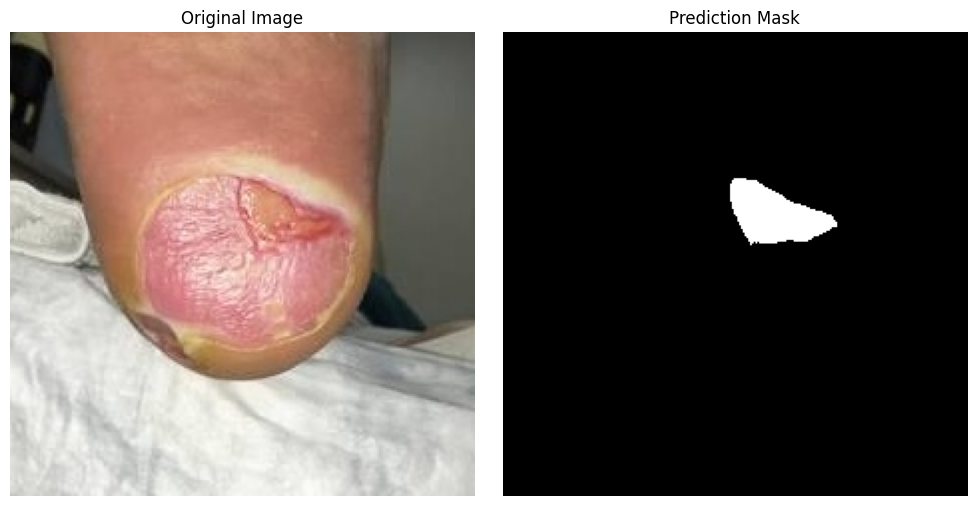

In [27]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# Load the trained model
model = load_model('unet_wound_segmentation_model.h5', custom_objects={'dice_coefficient': dice_coefficient, 'iou_metric': iou_metric})

def preprocess_image(image_path, target_size=(256, 256)):
    """
    Load and preprocess an image for prediction.

    Args:
        image_path (str): Path to the image file.
        target_size (tuple): Target size for resizing the image. Default is (256, 256).

    Returns:
        np.array: Preprocessed image.
    """
    # Load the image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
    image = cv2.resize(image, target_size)  # Resize to target size
    image = image / 255.0  # Normalize to [0, 1]
    image = np.expand_dims(image, axis=0)  # Add batch dimension
    return image

def display_prediction(image_path, model):
    """
    Display the original image and its prediction (segmentation mask).

    Args:
        image_path (str): Path to the image file.
        model (tf.keras.Model): Trained model for prediction.

    Returns:
        None
    """
    # Preprocess the image
    image = preprocess_image(image_path)

    # Generate prediction
    prediction = model.predict(image)
    prediction_mask = (prediction.squeeze() > 0.5).astype(np.uint8)  # Apply threshold (0.5)

    # Load the original image for display
    original_image = cv2.imread(image_path)
    original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)

    # Display the original image and the prediction
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(original_image)
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(prediction_mask, cmap='gray')
    plt.title('Prediction Mask')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

# Test the model on a new image
test_image_path = '/kaggle/input/wound-classification/Wound_dataset copy/Diabetic Wounds/119_0.jpg'  
display_prediction(test_image_path, model)

